# Exercise 2

**Please Note**: We updated the requirements.txt

Please install the new requirements before editing this exercise.

## Import packages

In [23]:
import os

from vll.utils.download import download_mnist
import numpy as np
import matplotlib.pyplot as plt

import skimage
import skimage.io

import torch
import torch.nn.functional as F
from torchvision import transforms

from models.mnist.simple_cnn import Net

## Task 1
(2 points)

In this task, you will learn some basic tensor operations using the PyTorch library.

Reference for torch: https://pytorch.org/docs/stable/torch.html

In [ ]:
# Create a numpy array that looks like this: [0, 1, 2, ..., 19]
arr = 

# Convert the numpy array to a torch tensor
tensor = 
print(tensor)

# Create a tensor that contains random numbers.
# It should have the same size like the numpy array.
# Multiply it with the previous tensor.
rand_tensor = 
tensor = 
print(tensor)

# Create a tensor that contains only 1s.
# It should have the same size like the numpy array.
# Substract it from the previous tensor.
tensor = 
print(tensor)

# Get the 5th element using a index.
element = 
print(element)

# Create a tensor that contains only 0s.
# It should have the same size like the numpy array.
# Multiply it with the previous tensor without any assignment (in place).


In [ ]:
# Load the image from the last exercise as RGB image.
image = 

# Convert the image to a tensor
image = 

# Print its shape
print(image.shape)

# Flatten the image
image = 
print(len(image))

# Add another dimension resulting in a 1x78643 tensor

print(image.shape)

# Revert the last action

print(image.shape)

# Reshape the tensor, so that it has the original 2D dimensions
image = 
print(image.shape)

# Calculate the sum, mean and max of the tensor
print(torch.sum(image))
print(torch.mean(image))
print(torch.max(image))

## Task 2
(2 points)

Use Autograd to perform operations on a tensor and output then gradients.

In [ ]:
# Create a random 2x2 tensor which requires gradients
x = 
print(x)

# Create another tensor by adding 2.0
y = 
print(y)

# Create a third tensor z = y^2
z = 
print(z)

# Compute out as the mean of values in z
out = 
print(out)

# Perform back propagation on out


# Print the gradients dout/dx


# Create a copy of y whithout gradients
y2 = 
print(y2.requires_grad)

# Perform the mean operation on z
# with gradients globally disabled


## Task 3
(3 points)

Implement a Dataset class for MNIST.

In [24]:
# We first download the MNIST dataset
download_mnist()

MNIST is ready!


In [29]:
class MNIST:
    """
    Dataset class for MNIST
    """

    def __init__(self, root, transform=None):
        """
        root -- path to either "training" or "testing"
        
        transform -- transform (from torchvision.transforms)
                     to be applied to the data
        """
        # Save transforms
        self.transform = transform

        # Explicitly get class names sorted numerically
        self.class_names = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))], key=int)
        self.image_paths = []
        self.labels = []

        for class_name in self.class_names:
            class_dir = os.path.join(root, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(int(class_name))  # Convert folder name to integer label

        
    def __len__(self):
        """
        Returns the length of the dataset (number of images)
        """
        return len(self.image_paths)

    def __getitem__(self, index):
        """
        Loads and returns one image as floating point numpy array
        
        index -- image index in [0, self.__len__() - 1]
        """
        # Load the image at the given index
        img_path = self.image_paths[index]
        img = skimage.io.imread(img_path).astype(np.float32)
        
        # Apply transforms to the image (if there are any)
        if self.transform:
            img = self.transform(img)
        
        # Return a tuple (transformed image, ground truth)
        return img, self.labels[index]


## Task 4
(3 points)

You can now load a pretrained neural network model we provide.
Your last task is to run the model on the MNIST test dataset, plot some example images with the predicted labels and compute the prediction accuracy.

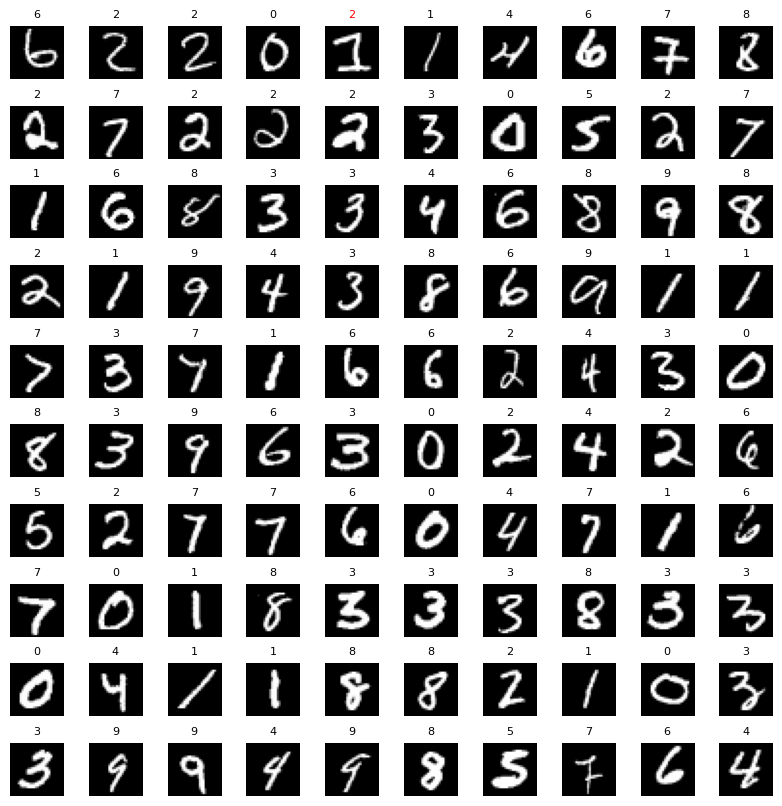

Prediction Accuracy: 98.20%


In [32]:
def validate(model, data_loader):
    # Create a 10x10 grid of subplots for the first 100 images
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5)
    
    model.eval()  # Set model to evaluation mode
    correct = 0   # Count for correct predictions
    
    with torch.no_grad():
        for i, item in enumerate(data_loader):
            # Unpack item into image and ground truth
            image, ground_truth = item
            ground_truth = ground_truth.item()  # Convert to integer if needed
            output = model(image)  # Run network on the image
            
            # Get class with the highest probability
            predicted_class = output.argmax(dim=1).item()  # Convert prediction to integer
            
            # Check if prediction is correct and add to correct count
            if predicted_class == ground_truth:
                correct += 1
            
            # Plot the first 100 images
            if i < 100:
                # Compute position of i-th image in the grid
                row, col = divmod(i, 10)
                
                # Convert image tensor to numpy array and normalize to [0, 1]
                img_np = image.squeeze().numpy()
                img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
                
                # Make wrongly predicted images red
                color = 'red' if predicted_class != ground_truth else 'black'
                
                # Disable axis and show image
                axes[row, col].axis('off')
                axes[row, col].imshow(img_np, cmap='gray')
                
                # Show the predicted class next to each image
                axes[row, col].set_title(predicted_class, color=color, fontsize=8)
        
        # Show plot after plotting the first 100 images
        plt.show()

    # Compute and print the prediction accuracy in percent
    accuracy = 100 * correct / len(data_loader.dataset)
    print(f'Prediction Accuracy: {accuracy:.2f}%')

    
# Create a DataLoader using the implemented MNIST dataset class
data_loader = torch.utils.data.DataLoader(
    MNIST('data/mnist/testing',
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=1, shuffle=True)

# Create the neural network
model = Net()

# Load the statedict from 'models/mnist/simple_cnn.pt'
model.load_state_dict(torch.load('models/mnist/simple_cnn.pt'))

# Validate the model
validate(model, data_loader)
